In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
import numpy as np
import imp
import matplotlib.pyplot as plt
import xgboost
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
import seaborn as sns
%matplotlib inline
from HelperClass.DataProcessing import *
from HelperClass.NN_Model import build_model

In [3]:
trainDataFile = 'Data/train.csv'
testDataFile = 'Data/test.csv'
dataTypes = {
    'PassengerId' : 'int64',
    'Survived' : 'int64',
    'Pclass' : 'int64',
    'Name' : 'object',
    'Sex' : 'object',
    'Age' : 'float64',
    'SibSp' : 'int64',
    'Parch' : 'int64',
    'Ticket' : 'object',
    'Fare' : 'float64',
    'Cabin' : 'object',
    'Embarked' : 'object'
}
sep = ','
target = 'Survived'
clusterIdCol = 'PassagerClusterId'
randomSeed = 83213
testRatio = 0.20
numCores = 15

In [4]:
dataProc = DataProcessing(trainDataFile, dataTypes, sep)
dataProc.ReadFile()
dataProc.AllData = dataProc.AllData[~dataProc.AllData.Embarked.isnull()]

submitDataProc = DataProcessing(testDataFile, dataTypes, sep)
submitDataProc.ReadFile()
submitDataProc.AllData = submitDataProc.AllData[~submitDataProc.AllData.Embarked.isnull()]

Findings
1. Age makes difference, F_onewayResult(statistic=4.271194933815904, pvalue=0.03912465401348333)
2. Fare makes difference, F_onewayResult(statistic=63.03076422804448, pvalue=6.120189341921873e-15)
3. PassengerId doesn't make difference, F_onewayResult(statistic=0.022284812266068058, pvalue=0.8813657768798144)
4. Pclass makes difference, F_onewayResult(statistic=115.03127218827665, pvalue=2.5370473879805644e-25)
5. SibSp doesn't make difference, F_onewayResult(statistic=1.110572204113227, pvalue=0.29224392869817906)
6. Parch makes difference, F_onewayResult(statistic=5.963463836603541, pvalue=0.0147992453747224)

In [5]:
def PopulateFeatures(data):
    data.Cabin.fillna('NA', inplace=True)
    data['CabinType'] = data.Cabin.fillna('NA').str.get(0)
    return data

In [6]:
dataProc.AllData = PopulateFeatures(dataProc.AllData)
submitDataProc.AllData = PopulateFeatures(submitDataProc.AllData)

In [7]:
dataProc.AllData['CabinType_B_D_E'] = np.where(dataProc.AllData.CabinType.isin(['B', 'D', 'E']), 2, 1)
submitDataProc.AllData['CabinType_B_D_E'] = np.where(submitDataProc.AllData.CabinType.isin(['B', 'D', 'E']), 2, 1)

In [8]:
dataProc.AllData.Age.fillna(-999, inplace=True)
submitDataProc.AllData.Age.fillna(-999, inplace=True)

In [9]:
bins = [-10000, 0, 20, 60, 1000]
dataProc.AllData['AgeGroup'] = pd.cut(dataProc.AllData.Age, bins).astype(str)
submitDataProc.AllData['AgeGroup'] = pd.cut(submitDataProc.AllData.Age, bins).astype(str)

In [10]:
dataProc.AllData['GenderAgeGroup'] = dataProc.AllData.Sex + '_' + dataProc.AllData.AgeGroup
submitDataProc.AllData['GenderAgeGroup'] = submitDataProc.AllData.Sex + '_' + submitDataProc.AllData.AgeGroup

In [11]:
dataProc.AllData.groupby(['GenderAgeGroup']).agg({'Survived' : ['mean', 'count']}).sort_values(by=('Survived', 'mean'), 
                                                                                               ascending=False)

Survived      
                        mean count
GenderAgeGroup                    
female_(60, 1000]   1.000000     2
female_(20, 60]     0.777778   180
female_(0, 20]      0.688312    77
female_(-10000, 0]  0.679245    53
male_(0, 20]        0.284314   102
male_(20, 60]       0.186747   332
male_(-10000, 0]    0.129032   124
male_(60, 1000]     0.105263    19

In [12]:
genderAgeGroups = {
    'GenderAgeGroup' : {
        'female_(20, 60]' : 7, 
        'female_(60, 1000]' : 8,
        'female_(0, 20]' : 6, 
        'female_(-10000, 0]' : 5,
        'male_(0, 20]' : 4, 
        'male_(20, 60]' : 3, 
        'male_(-10000, 0]' : 2, 
        'male_(60, 1000]' : 1
    }
}

In [13]:
dataProc.AllData.replace(genderAgeGroups, inplace=True)
submitDataProc.AllData.replace(genderAgeGroups, inplace=True)

In [14]:
dataProc.AllData['Sex'] = np.where(dataProc.AllData['Sex'] == 'male', 1, 2)
submitDataProc.AllData['Sex'] = np.where(submitDataProc.AllData['Sex'] == 'male', 1, 2)

In [15]:
embarkedEncoding = {
    'Embarked' : {
       'S' : 1,
       'Q' : 1,
       'C' : 2
    }
}

In [16]:
dataProc.AllData.replace(embarkedEncoding, inplace=True)
submitDataProc.AllData.replace(embarkedEncoding, inplace=True)

In [17]:
numCols = ['Fare', 'Pclass', 'Parch', 'CabinType_B_D_E', 'GenderAgeGroup', 'Embarked', 'Sex']

In [18]:
columnsToFindCluster = ['Pclass', 'GenderAgeGroup', 'Parch']

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
trainingCopy = dataProc.AllData[columnsToFindCluster]
trainingCopy = scaler.fit_transform(trainingCopy)
submitDataCopy = scaler.transform(submitDataProc.AllData[columnsToFindCluster])

In [20]:
trainingCopy[:, 0] = trainingCopy[:, 0] * 10
trainingCopy[:, 1] = trainingCopy[:, 1] * 5
trainingCopy[:, 2] = trainingCopy[:, 2]  

submitDataCopy[:, 0] = submitDataCopy[:, 0] * 10
submitDataCopy[:, 1] = submitDataCopy[:, 1] * 5
submitDataCopy[:, 2] = submitDataCopy[:, 2]

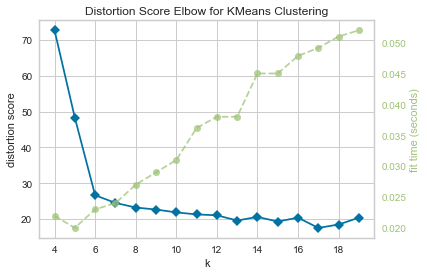

In [21]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(4,20))
visualizer.fit(trainingCopy) 
visualizer.poof()

In [22]:
kmeans = KMeans(n_clusters=6, random_state=randomSeed).fit(trainingCopy)

In [23]:
numCols.append(clusterIdCol)

In [24]:
dataProc.AllData[clusterIdCol] = kmeans.labels_.astype(str)

In [25]:
dataProc.AllData.groupby([clusterIdCol])[target].mean().sort_values()

PassagerClusterId
4    0.135447
0    0.157407
3    0.368852
1    0.500000
5    0.921053
2    0.967391
Name: Survived, dtype: float64

In [26]:
submitDataProc.AllData[clusterIdCol] = kmeans.predict(submitDataCopy).astype(str)

In [27]:
submitDataProc.AllData[submitDataProc.AllData.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinType,CabinType_B_D_E,AgeGroup,GenderAgeGroup,PassagerClusterId
152,1044,3,"Storey, Mr. Thomas",1,60.5,0,0,3701,NaN,NA,1,N,1,"(60, 1000]",1,4


In [28]:
averageFare = submitDataProc.AllData[submitDataProc.AllData.PassagerClusterId == '4'].Fare.mean()
submitDataProc.AllData.Fare.fillna(averageFare, inplace=True)

In [29]:
clusterMapping = {
    clusterIdCol : {
        '4' : 1,
        '0' : 1,
        '3' : 2,
        '1' : 4,
        '5' : 6,
        '2' : 6,
    }
}

In [30]:
dataProc.AllData.replace(clusterMapping, inplace=True)
submitDataProc.AllData.replace(clusterMapping, inplace=True)

In [31]:
dataProc.PopulateFeatureColumns(numCols)
submitDataProc.PopulateFeatureColumns(numCols)

In [32]:
dataProc.y = dataProc.AllData[target]

In [33]:
dataProc.RandomSplitTrainTestData(testRatio, randomSeed, True)

In [34]:
dataProc.X.dtypes

Fare                 float64
Pclass                 int64
Parch                  int64
CabinType_B_D_E        int32
GenderAgeGroup         int64
Embarked               int64
Sex                    int32
PassagerClusterId      int64
dtype: object

In [35]:
preProc = ColumnTransformer([
    ('StdScaler', StandardScaler(), numCols),
    #('pca', PCA(n_components = 5), ['Embarked', 'Parch', 'CabinType_B_D_E'])
])

## Random forest model

In [36]:
rf = RandomForestClassifier(random_state = randomSeed)
rfpipeline = Pipeline([#('preProcessing', preProc),
                       ('rf', rf)])
params = {
   # 'ReduceDim__k' : range(5, 11),
    'rf__n_estimators' : range(3, 20),
    'rf__max_depth' : range(1, 5),
    'rf__max_features' : ['sqrt', 'log2', None]
}
rfcv = RandomizedSearchCV(rfpipeline, n_iter= 100, scoring = 'accuracy', 
                          param_distributions=params, verbose=1, cv = 10, n_jobs = numCores, random_state=randomSeed)

In [37]:
#rfcv.fit(dataProc.X_train, dataProc.y_train)

In [38]:
#rfcv.best_params_

In [39]:
#y_train_stacking_pred = rfcv.predict(dataProc.X_train)
#print('Stacking %.3f ' % accuracy_score(dataProc.y_train, y_train_stacking_pred))
#
#y_test_stacking_pred = rfcv.predict(dataProc.X_test)
#print('Stacking %.3f ' % accuracy_score(dataProc.y_test, y_test_stacking_pred))

## XGB model

In [40]:
param_grid = {
    'xgb__max_depth' : [3, 4, 5, 6],
    'xgb__learning_rate' : [0.05, 0.1, 0.2],
    'xgb__n_estimators' : range(5, 21),
    'xgb__subsample' : [0.8, 0.9, 0.95],
    'xgb__colsample_bytree' : [0.8, 0.9, 0.95],
    'xgb__reg_alpha' : [0.05, 0.1, 0.2, 0.4],
    'xgb__reg_lambda' : [0.05, 0.1, 0.2, 0.4],
    'xgb__gamma' : [0.0001, 0.001, 0.01, 0.1]
}

xgb = xgboost.XGBClassifier(seed=randomSeed)
xgbpipeline = Pipeline([#('preProcessing', preProc),
                        ('xgb', xgb)])
xgbcv = RandomizedSearchCV(xgbpipeline, n_iter = 50, cv=10, param_distributions =param_grid, 
                        scoring='accuracy', verbose = 1, n_jobs = numCores, random_state=randomSeed)

## AdaBoost

In [41]:
from sklearn.ensemble import AdaBoostClassifier
param_grid = {
    'ada__learning_rate' : [0.05, 0.1, 0.2],
    'ada__n_estimators' : range(5, 21)
}
ada = AdaBoostClassifier(n_estimators=100, random_state=randomSeed)
adapipeline = Pipeline([('ada', ada)])
adacv = RandomizedSearchCV(adapipeline, n_iter = 50, cv=10, param_distributions =param_grid,
                           scoring='accuracy', verbose = 1, n_jobs = numCores, random_state=randomSeed)

## Logistic regression

In [42]:
from sklearn import linear_model
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(0, 4, 10),
    'solver' : ['liblinear', 'saga']
}
C = np.logspace(0, 4, 10)
logistic = linear_model.LogisticRegression()
logisticCV = GridSearchCV(logistic, param_grid, cv=10, verbose=1) 

## SVC

In [43]:
from sklearn.svm import SVC
clf = SVC(gamma='auto', probability=True)

## Model stacking

In [44]:
from mlens.ensemble import SuperLearner
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
ensemble = SuperLearner(scorer=accuracy_score, random_state=randomSeed)
estimators = [rfcv, xgbcv, adacv, clf]
ensemble.add(estimators, proba=True)   # Specify 'proba' here
ensemble.add_meta(logisticCV)

[MLENS] backend: threading


SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=4761, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...BD5F620>)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=83213, sample_size=20,
       scorer=<function accuracy_score at 0x000001D6CBD5F620>,
       shuffle=False, verbose=False)

In [45]:
ensemble.fit(dataProc.X_train, dataProc.y_train)

[Parallel(n_jobs=15)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=15)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=15)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=15)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 50 candidates, totalling 500 fitsFitting 10 folds for each of 50 candidates, totalling 500 fits

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Fitting 10 folds for each of 48 candidates, totalling 480 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fitsFitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 48 candidates, totalling 480 fits



[Parallel(n_jobs=15)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=15)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=15)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=15)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=15)]: Done 500 out of 500 | elapsed:   22.2s finished
[Parallel(n_jobs=15)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=15)]: Done 500 out of 500 | elapsed:   22.6s finished
[Parallel(n_jobs=15)]: Done 500 out of 500 | elapsed:   28.3s finished
[Parallel(n_jobs=15)]: Done 480 out of 480 | elapsed:   52.6s finished
[Parallel(n_jobs=15)]: Done 480 out of 480 | elapsed:   43.4s finished
[Parallel(n_jobs=15)]: Done 1000 out of 1000 | elapsed:  1.3min finished
[Parallel(n_jobs=15)]: Done 1000 out of 1000 | elapsed:  1.3min finished
[Parallel(n_jobs=15)]: Done 480 out of 480 | elapsed:  1.3min finished
[Parallel(n_jobs=15)]: Done 1000 out of 1000 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.4s finished


SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=4761, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...BD5F620>)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=83213, sample_size=20,
       scorer=<function accuracy_score at 0x000001D6CBD5F620>,
       shuffle=False, verbose=False)

In [46]:
y_train_stacking_pred = ensemble.predict(dataProc.X_train)
print('Stacking %.3f ' % accuracy_score(dataProc.y_train, y_train_stacking_pred))

Stacking 0.837 


In [47]:
y_test_stacking_pred = ensemble.predict(dataProc.X_test)
print('Stacking %.3f ' % accuracy_score(dataProc.y_test, y_test_stacking_pred))

Stacking 0.803 


In [48]:
submitDataProc.AllData[target] = ensemble.predict(submitDataProc.X.reindex(columns=numCols)).astype('int')
submitDataProc.AllData[['PassengerId', 'Survived']].to_csv('submit.txt', index=False)